<a href="https://colab.research.google.com/github/JarnovdKolk/Test/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### I used the pre-trained EfficientNetV2B0 model from TensorFlow's Keras Applications, excluding the top layers, and added a custom classification head for the Galaxy Zoo task. The base model was frozen during the initial training phase, and only the final layer was trained. Data augmentation was applied to the input images to improve generalization. A learning rate scheduler (ReduceLROnPlateau) was used to adjust the learning rate based on validation loss. I also tried some different strategies, which I will explain as they come up.

Note: The model could not be properly trained on a large dataset due to GPU usage limits in Google Colab (apparrently you can only use so much GPU before it is switched off. There is also no indication how long it will take before you can use it again. Unfortunately, I didn't have enough time to setup something locally). As a result, only a small dataset was used, but the fine-tuning concept remains the same and would be applicable with a larger dataset. The accuracies are sometimes a bit weird, but I could not run this on bigger data sets, because these codes already took an hour and this could be the cause.

In [ ]:
!pip install torch torchvision timm pandas pillow scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Define paths
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/images_training_rev1GOED"
LABELS_CSV = "/content/drive/MyDrive/Colab Notebooks/training_solutions_rev1GOED.csv"

NUM_CLASSES = 37  # Number of output classes for Galaxy Zoo


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Define paths
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/images_training_rev1GOED"  # Path to images
LABELS_CSV = "/content/drive/MyDrive/Colab Notebooks/training_solutions_rev1GOED.csv"

# Number of images to use
NUM_IMAGES = 1000

# Load all image filenames
image_filenames = sorted(os.listdir(DATA_DIR))[:NUM_IMAGES]  # Get first NUM_IMAGES image filenames
image_ids = [int(img_name.split('.')[0]) for img_name in image_filenames]  # Extract GalaxyIDs from filenames

# Load the labels CSV
labels_df = pd.read_csv(LABELS_CSV)

# Filter labels to only include those corresponding to the images
labels_df = labels_df[labels_df['GalaxyID'].isin(image_ids)]

# Sort labels by GalaxyID to match the order of images
labels_df = labels_df.set_index('GalaxyID').loc[image_ids].reset_index()

# Load and preprocess images
images = []
for img_name in image_filenames:
    img_path = os.path.join(DATA_DIR, img_name)
    try:
        img = image.load_img(img_path, target_size=(224, 224))  # Resize to 224x224, which is necessary for the model
        img_array = image.img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img_array)
    except Exception as e:
        print(f"Skipping {img_name} due to error: {e}")

# Convert images to a numpy array
images = np.array(images)

# Extract labels (drop the 'GalaxyID' column)
labels = labels_df.drop(columns=['GalaxyID']).values

# Verify shapes
print("Images shape:", images.shape)  # Should be (NUM_IMAGES, 224, 224, 3)
print("Labels shape:", labels.shape)  # Should be (NUM_IMAGES, 37)


Images shape: (1000, 224, 224, 3)
Labels shape: (1000, 37)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 58s 910ms/step - accuracy: 0.0577 - loss: 23.1210 - val_accuracy: 0.6650 - val_loss: 16.1758 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 827ms/step - accuracy: 0.3349 - loss: 19.6747 - val_accuracy: 0.6650 - val_loss: 17.6243 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 849ms/step - accuracy: 0.5415 - loss: 22.6015 - val_accuracy: 0.6650 - val_loss: 24.9786 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.5299 - loss: 31.9903
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 831ms/step - accuracy: 0.5299 - loss: 32.0583 - val_accuracy: 0.6650 - val_loss: 36.6334 - learning_rate: 0.0010
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 836ms/step - accuracy: 0.5432 - loss: 45.1326 - val_accuracy: 0.6650 - val_loss: 43.7645 - learning_rate: 5.0000e-04
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 850ms/step - accuracy: 0.54

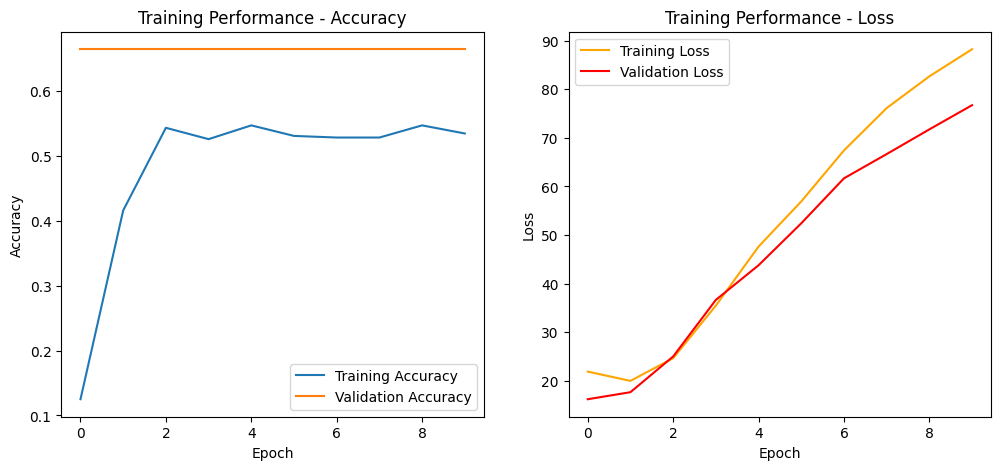

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Data Augmentation
augmentor = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Load EfficientNetV2 without top layers
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # Stabilizes training
x = Dropout(0.3)(x)  # Dropout for regularization
x = Dense(37, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x) #Softmax since there are multiple classes

model = Model(inputs=base_model.input, outputs=x)

# Compile model with higher learning rate for final layer
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)


# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert one-hot encoded labels (y_train) to class indices
class_indices_train = np.argmax(y_train, axis=1)

# Compute class weights based on the class indices
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(class_indices_train),
    y=class_indices_train  # The class labels for each image
)

# Convert class weights to a dictionary (needed for class_weight argument)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train Model
history = model.fit(
    augmentor.flow(X_train, y_train, batch_size=16),
    epochs=10,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[lr_scheduler]
)
# Evaluate model
loss, accuracy = model.evaluate(images, labels)
print(f"Final Loss: {loss}, Final Accuracy: {accuracy}")

# Plot training history
def plot_training(history, title="Training Performance"):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title + ' - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='orange')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.title(title + ' - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training(history, "Training Performance")


Before, I froze the entire base model, training only the final classification layers. Now, I unfreeze the last 30 layers, allowing the model to learn deeper features for better accuracy. Before, I used class weights to handle imbalanced data. Now, I skip class weights, assuming the dataset is balanced. Before, I trained for a fixed 10 epochs, no matter what. Now, I add EarlyStopping, so training stops automatically if validation loss stops improving. Before, I used a high learning rate (1e-3) since I was only training the last layer. Now, I lower it to 5e-5, making fine-tuning more stable.

The results is that now both the training and validation losses are decreasing, which is supposed to happen. The accuracy is slowly increasing, but the validation accuracy is suddenly spiking, which could be caused by several different reasons, which I try to fix in the next model.

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 948ms/step - accuracy: 0.0212 - loss: 22.3494 - val_accuracy: 0.0000e+00 - val_loss: 18.2554 - learning_rate: 5.0000e-05
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 912ms/step - accuracy: 0.0179 - loss: 20.7394 - val_accuracy: 0.0750 - val_loss: 18.1203 - learning_rate: 5.0000e-05
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 896ms/step - accuracy: 0.0354 - loss: 20.2479 - val_accuracy: 0.0750 - val_loss: 17.9652 - learning_rate: 5.0000e-05
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 864ms/step - accuracy: 0.0571 - loss: 20.1708 - val_accuracy: 0.0750 - val_loss: 17.7833 - learning_rate: 5.0000e-05
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 882ms/step - accuracy: 0.0503 - loss: 19.6585 - val_accuracy: 0.0000e+00 - val_loss: 17.5879 - learning_rate: 5.0000e-05
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 854ms/step - accuracy: 0.0532 - loss: 19.4831 - val_accuracy: 0.0000e+00 - val_loss: 17.5974 - learning_rate: 5.0000e-05
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━

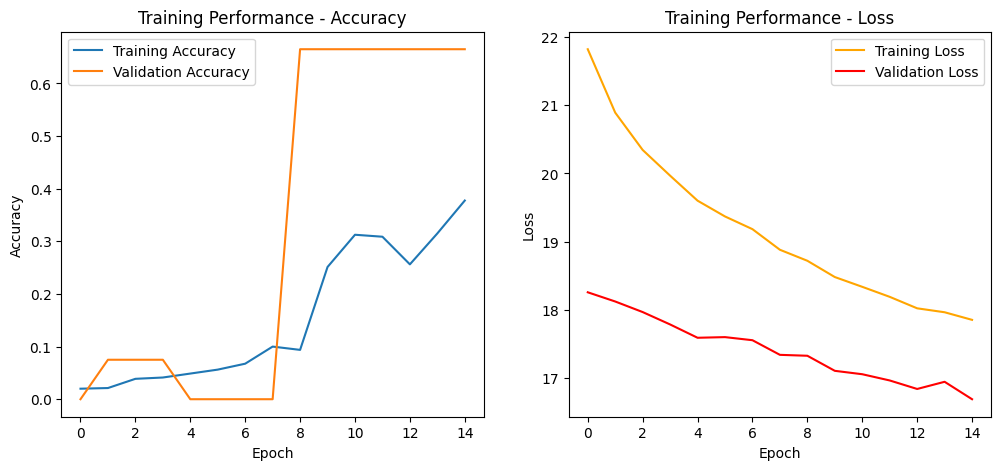

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

# Data Augmentation (to improve generalization)
augmentor = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Load EfficientNetV2B0 without top layers
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# **Fine-tuning strategy**: Unfreeze the last 30 layers for training
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Build the classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # Helps stabilize training
x = Dropout(0.1)(x)  # Reduced dropout to prevent excessive regularization
x = Dense(37, activation='softmax')(x)  # 37-class classification

# Create the model
model = Model(inputs=base_model.input, outputs=x)

# Compile with lower learning rate
model.compile(optimizer=Adam(learning_rate=5e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Learning Rate Reduction Callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Train model WITHOUT class weights initially
history = model.fit(
    augmentor.flow(X_train, y_train, batch_size=16),
    epochs=15,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler, early_stopping]
)

# Evaluate model on full dataset
loss, accuracy = model.evaluate(images, labels)
print(f"Final Loss: {loss}, Final Accuracy: {accuracy}")

# Plot training history
def plot_training(history, title="Training Performance"):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title + ' - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='orange')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.title(title + ' - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Show training performance
plot_training(history, "Training Performance")


Before, I used EfficientNetV2B0 with a lower learning rate and focused on early stopping to avoid overfitting. Now, I switch to EfficientNetV2S with a higher learning rate and AdamW optimizer, which helps speed up training and improve generalization. Before, I only applied basic data augmentation. Now, I add more augmentation techniques like random flipping and rotation to create a more diverse dataset. Before, I froze most of the base model during training. Now, I fine-tune the model by unfreezing more layers to allow it to learn deeper features.

Images shape: (1000, 224, 224, 3)
Labels shape: (1000, 37)
82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 0.3536 - loss: 3.8708 - val_accuracy: 0.6650 - val_loss: 1.5104 - learning_rate: 0.0010
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.6285 - loss: 1.1603 - val_accuracy: 0.6650 - val_loss: 0.5250 - learning_rate: 0.0010
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.5909 - loss: 0.4592 - val_accuracy: 0.6650 - val_loss: 0.3454 - learning_rate: 0.0010
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.6482 - loss: 0.3358 - val_accuracy: 0.6650 - val_loss: 0.3169 - learning_rate: 0.0010
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.5892 - loss: 0.3209 - val_accuracy: 0.6650 - val_loss: 0.3086 - learning_rate: 0.0010
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.6049 - loss: 0.3110 - val_accuracy: 0.6650 - val_loss: 0.3039 - learni

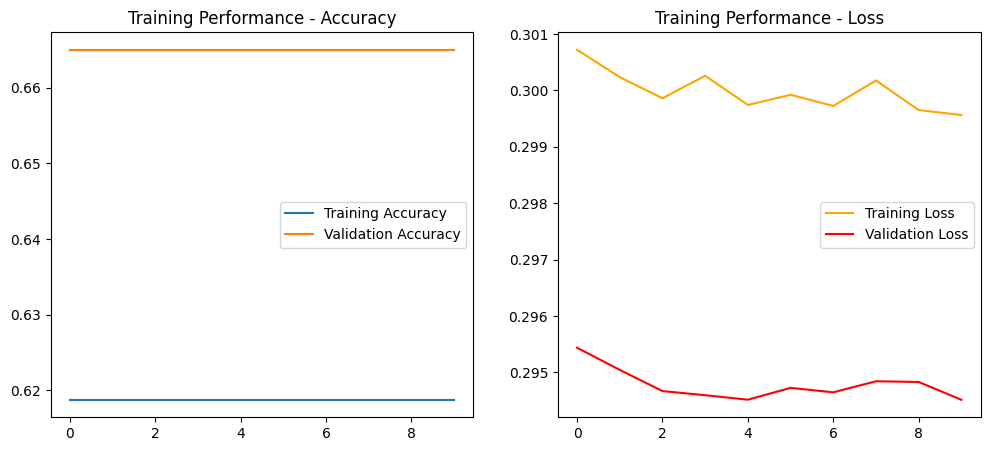

In [6]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define paths
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/images_training_rev1GOED"
LABELS_CSV = "/content/drive/MyDrive/Colab Notebooks/training_solutions_rev1GOED.csv"

# Number of images to use
NUM_IMAGES = 1000

# Load all image filenames
image_filenames = sorted(os.listdir(DATA_DIR))[:NUM_IMAGES]
image_ids = [int(img_name.split('.')[0]) for img_name in image_filenames]

# Load labels CSV
labels_df = pd.read_csv(LABELS_CSV)
labels_df = labels_df[labels_df['GalaxyID'].isin(image_ids)]
labels_df = labels_df.set_index('GalaxyID').loc[image_ids].reset_index()

# Load and preprocess images
images = []
for img_name in image_filenames:
    img_path = os.path.join(DATA_DIR, img_name)
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0  # Normalize to [0,1]
        images.append(img_array)
    except Exception as e:
        print(f"Skipping {img_name} due to error: {e}")

images = np.array(images)
labels = labels_df.drop(columns=['GalaxyID']).values

print("Images shape:", images.shape)  # (NUM_IMAGES, 224, 224, 3)
print("Labels shape:", labels.shape)  # (NUM_IMAGES, 37)

# ---- DATA AUGMENTATION ----
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# ---- CREATE THE MODEL ----
base_model = EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model initially

# Define the classification head
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,  # Apply augmentation
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),  # Regularization
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),  # Additional dropout
    layers.Dense(37, activation='sigmoid')  # Multi-label classification
])

# Compile the model
optimizer = optimizers.AdamW(learning_rate=0.001, weight_decay=1e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# ---- TRAINING ----
batch_size = 32
epochs = 15

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

history = model.fit(
    images, labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    shuffle=True,
    callbacks=[lr_scheduler]
)

# ---- FINE-TUNE THE MODEL ----
# Unfreeze some layers in the base model
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Keep most layers frozen
    layer.trainable = False

# Recompile with a lower learning rate
model.compile(optimizer=optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
              loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune for more epochs
fine_tune_epochs = 10
history_finetune = model.fit(
    images, labels,
    batch_size=batch_size,
    epochs=fine_tune_epochs,
    validation_split=0.2,
    shuffle=True,
    callbacks=[lr_scheduler]
)

# ---- PLOT TRAINING RESULTS ----
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training Performance - Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='orange')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='red')
    plt.legend()
    plt.title('Training Performance - Loss')

    plt.show()

plot_training(history_finetune)
